# OU process

The SDE for the Ornstein-Uhlenbeck process, with long-term mean, is given by

$$
dx = \frac{1}{\tau} (\mu - x) dt + \sigma dW
$$

The equivalent GP kernel is given by

$$
k(x, x') = \frac{\sigma^2 \tau}{2} \exp\left(-\frac{|x - x'|}{\tau}\right)
$$

In [4]:
# for Gaussian processes this is important
from jax import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

from jaxns import marginalise_dynamic
from jax.scipy.linalg import solve_triangular
from jax import random
from jax import numpy as jnp
import pylab as plt
import numpy as np



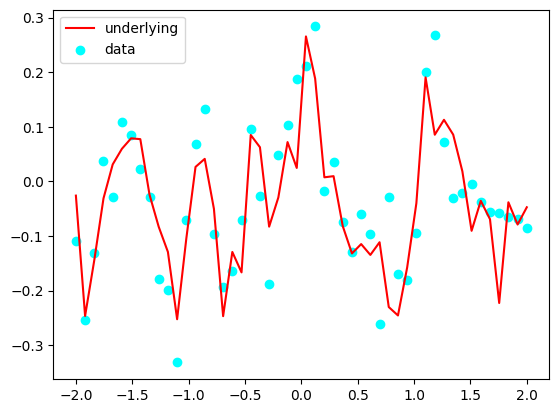

In [5]:
N = 50
num_outliers = int(0.15 * N)
np.random.seed(42)
X = jnp.linspace(-2., 2., N)[:, None]
true_tau, true_sigma = 0.2, np.sqrt(0.2)
true_scale = true_tau
true_amplitude = jnp.sqrt(true_sigma ** 2 * true_tau / 2)
true_noise = 0.5 * true_amplitude
data_mu = jnp.zeros((N,))
prior_cov = tfpk.MaternOneHalf(amplitude=true_amplitude, length_scale=true_scale).matrix(X, X) + 1e-13 * jnp.eye(N)

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,)) + data_mu
Y_obs = Y + true_noise * random.normal(random.PRNGKey(1), shape=(N,))

plt.plot(X[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
plt.legend()
plt.show()


INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 567477
samples: 6200
phantom samples: 0
likelihood evals / sample: 91.5
phantom fraction (%): 0.0%
--------
logZ=29.05 +- 0.14
max(logL)=38.29
H=-5.74
ESS=1077
--------
mu: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
mu: -0.038 +- 0.062 | -0.111 / -0.04 / 0.036 | -0.039 | -0.039
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 0.407 +- 0.086 | 0.296 / 0.417 / 0.5 | 0.49 | 0.49
--------
tau: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tau: 0.53 +- 0.62 | 0.18 / 0.29 / 1.15 | 0.16 | 0.16
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.048 +- 0.026 | 0.015 / 0.045 / 0.084 | 0.007 | 0.007
--------


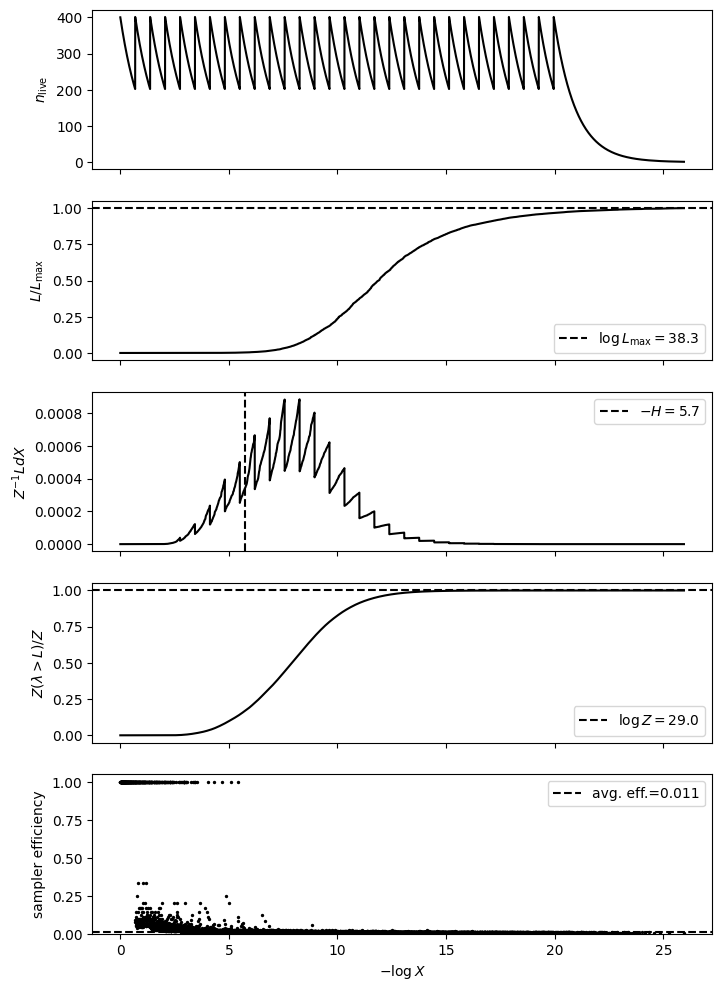

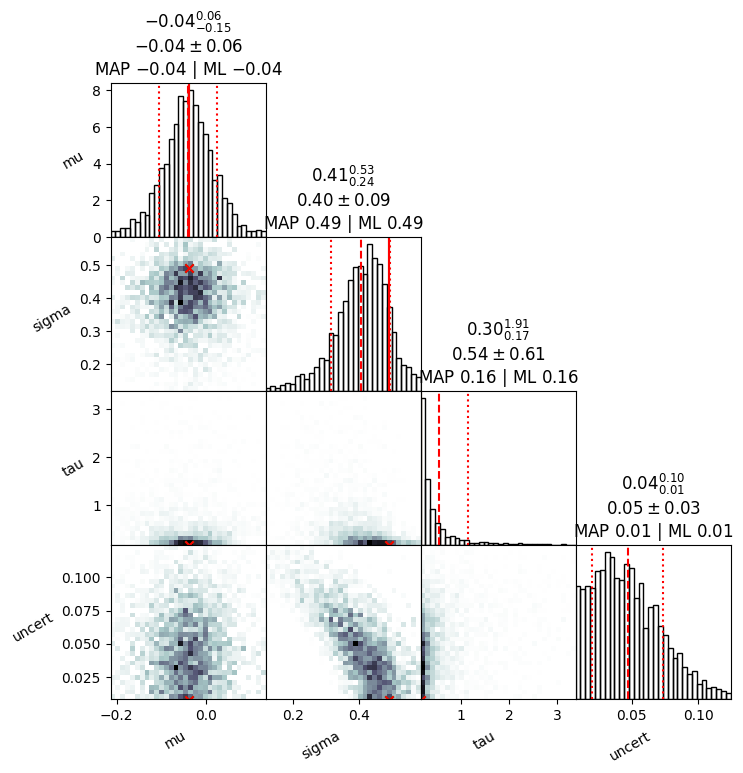

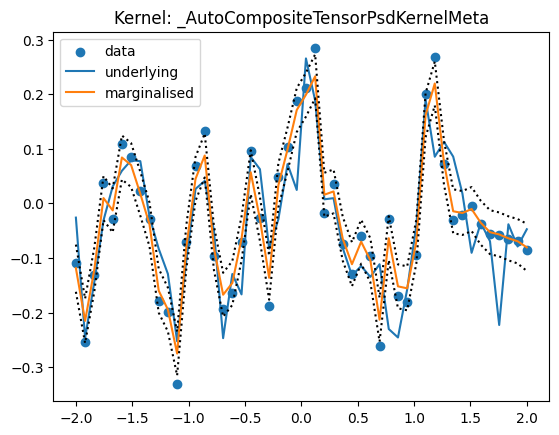

In [6]:


import jax
from jaxns import Prior, Model, NestedSampler

kernel = tfpk.MaternOneHalf

# X should be sorted
y_mean = jnp.mean(Y_obs)
y_std = jnp.std(Y_obs)
rmsd = jnp.sqrt(jnp.mean(jnp.square(jnp.diff(Y_obs, axis=0))))
mean_dt = jnp.mean(jnp.diff(X, axis=0))
min_tau = mean_dt * 2
max_tau = jnp.max(X) - jnp.min(X)


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    # U, S, Vh = jnp.linalg.svd(cov)
    log_det = jnp.sum(jnp.log(jnp.diag(L)))  # jnp.sum(jnp.log(S))#
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    # U S Vh V 1/S Uh
    # pinv = (Vh.T.conj() * jnp.where(S!=0., jnp.reciprocal(S), 0.)) @ U.T.conj()
    maha = dx @ dx  # dx @ pinv @ dx#solve_triangular(L, dx, lower=True)
    log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) - log_det - 0.5 * maha
    return log_likelihood


def log_likelihood(uncert, tau, sigma, mu):
    """
    P(Y|sigma, half_width) = N[Y, f, K]
    Args:
        sigma:
        l:

    Returns:

    """
    amplitude = jnp.sqrt(sigma ** 2 * tau / 2)
    scale = tau
    K = kernel(amplitude=amplitude, length_scale=scale).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return log_normal(Y_obs, mu, K + data_cov)


def predict_f(uncert, tau, sigma, mu):
    amplitude = jnp.sqrt(sigma ** 2 * tau / 2)
    scale = tau
    K = kernel(amplitude=amplitude, length_scale=scale).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return mu + K @ jnp.linalg.solve(K + data_cov, Y_obs - mu)


def predict_fvar(uncert, tau, sigma, mu):
    amplitude = jnp.sqrt(sigma ** 2 * tau / 2)
    scale = tau
    K = kernel(amplitude=amplitude, length_scale=scale).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return jnp.diag(K - K @ jnp.linalg.solve(K + data_cov, K))


# Build the model

def prior_model():
    tau = yield Prior(tfpd.Uniform(min_tau, max_tau), name='tau')
    # if 1/2 diff is noise, then rms(d/2) is noise
    uncert = yield Prior(tfpd.Uniform(true_noise*0.1, true_noise*10.), name='uncert')
    # amplitude = jnp.sqrt(sigma ** 2 * tau / 2)
    # sigma = sqrt(2 / tau) * amplitude
    mean_sigma = jnp.sqrt(2 / tau) * y_std  # if dX is sigma dW then rms(dX/dt) = sigma
    sigma = yield Prior(tfpd.Exponential(1. / mean_sigma), name='sigma')
    mu = yield Prior(tfpd.Normal(y_mean, y_std), name='mu')
    return uncert, tau, sigma, mu


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

# Create the nested sampler class. In this case without any tuning.
exact_ns = NestedSampler(model=model, difficult_model=True)

termination_reason, state = jax.jit(exact_ns)(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)

exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                results.ESS, predict_f)

predict_fvar = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                   results.ESS, predict_fvar)

plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(X[:, 0], Y, label='underlying')
plt.plot(X[:, 0], predict_f, label='marginalised')
plt.plot(X[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.plot(X[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()

logZ_m12, logZerr_m12 = results.log_Z_mean, results.log_Z_uncert